# Train

In [ ]:
%pip install torch transformers timm einops datasets bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires

In [ ]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split

import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset
import requests
from PIL import Image
from io import BytesIO

class CustomImageDataset(Dataset):
    def __init__(self, csv_file):
        # Load the CSV file into a pandas DataFrame
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get the row corresponding to the given index
        row = self.data.iloc[idx]

        # Extract the image URL and entity name
        image_url = row['image_link']
        entity_name = row['entity_name']
        entity_value = row['entity_value']

        # Replace underscores in entity_name with spaces
        entity_name_cleaned = entity_name.replace('_', ' ')

        # Download and open the image in grayscale
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert('L')

         # Create the prompt using the cleaned entity name
        prompt = f"""Extract {entity_name_cleaned} from the image in the format 'x unit', where: 'x' is a float number in standard formatting.'unit' is one of the allowed units for {entity_name_cleaned} from the following list: {', '.join(entity_unit_map[entity_name])}.Ensure that the output strictly matches the format "x unit" with a space separating the number and the unit. Do not use any abbreviations, special characters, or additional text. If no valid value is found in the image, return a string "blank" """

        # Return the sample with its original index
        return {
            "index": idx,  # Keep track of the original index
            "image": img,  # Grayscale PIL image
            "qa": [
                {
                    "question": prompt,
                    "answer": entity_value
                }
            ]
        }


# Usage example:
# Assuming 'data.csv' is your CSV file with the required columns
train_dataset = CustomImageDataset('/content/error_free_train.csv')

In [ ]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-07-23"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/moondream-ft_large_prompt_after_10000_iterations", revision=MD_REVISION, trust_remote_code=True,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

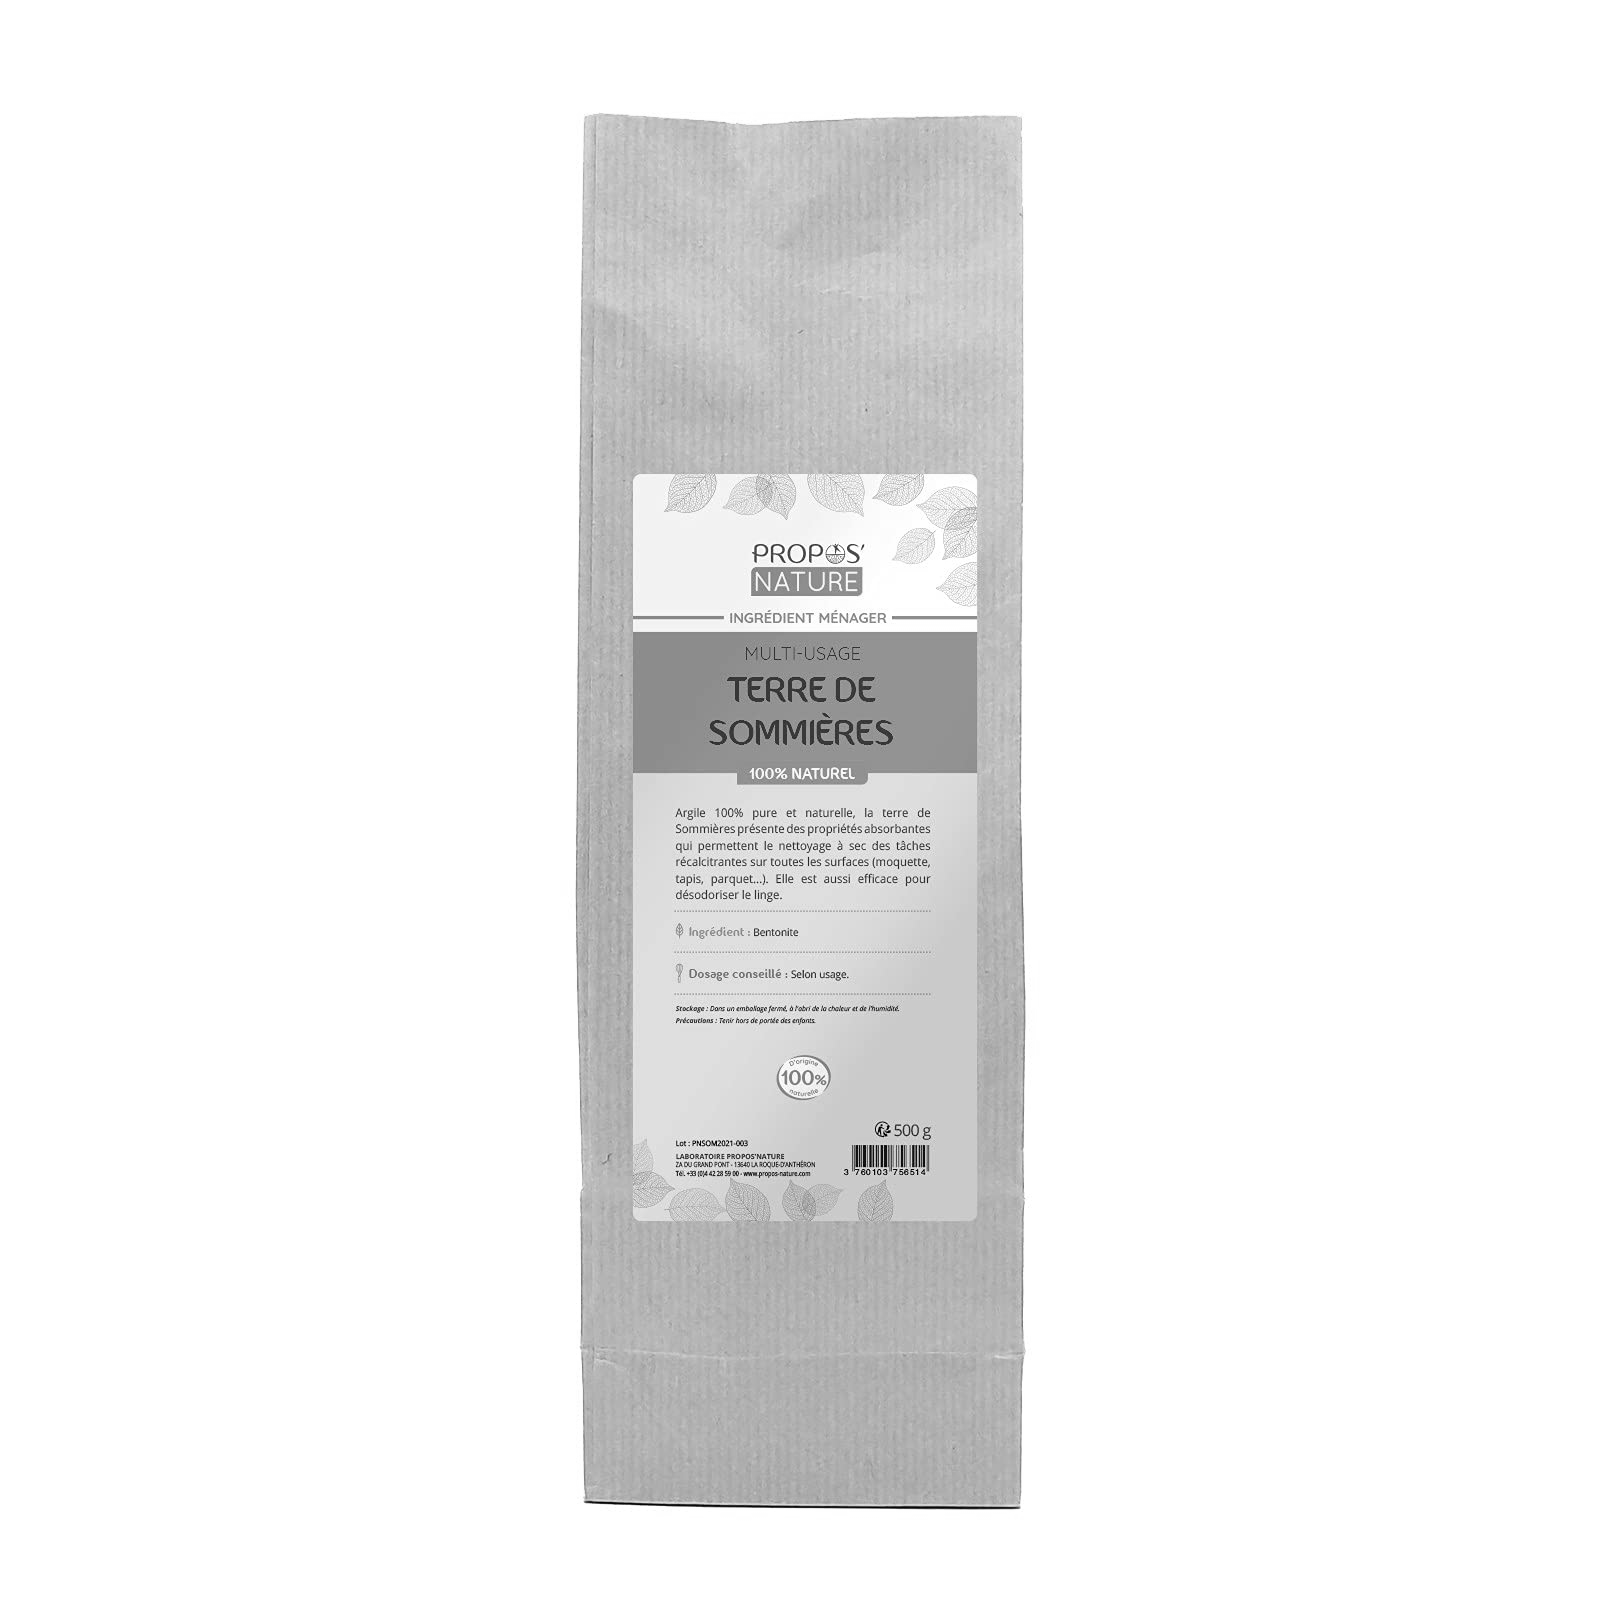

Question: Extract item weight from the image in the format 'x unit', where: 'x' is a float number in standard formatting.'unit' is one of the allowed units for item weight from the following list: gram, microgram, pound, ounce, kilogram, ton, milligram.Ensure that the output strictly matches the format "x unit" with a space separating the number and the unit. Do not use any abbreviations, special characters, or additional text. If no valid value is found in the image, return a string "blank" 
Ground Truth: 500.0 gram
Moondream: 300.0 gram


In [ ]:
from IPython.display import display

sample = train_dataset[0]
display(sample['image'])

for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    print('Moondream:', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

In [ ]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 1

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory.
BATCH_SIZE = 8

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 2

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 1e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False

In [ ]:
# Import necessary libraries
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO
import torch

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import torch

def collate_fn(batch):
    images = []
    labels_acc = []
    tokens_acc = []

    for sample in batch:
        try:
            # Check if the sample['image'] is a PIL Image object directly
            if isinstance(sample['image'], Image.Image):
                # Process the image directly since it is already loaded
                image = moondream.vision_encoder.preprocess(sample['image'].convert('RGB'))  # Ensure image is in RGB
                images.append(image)
            else:
                # If not a PIL Image, handle as URL
                try:
                    response = requests.get(sample['image'], timeout=5)
                    response.raise_for_status()  # Check if the request was successful

                    # Verify that the response content is actually an image
                    img = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB
                    image = moondream.vision_encoder.preprocess(img)
                    images.append(image)

                except requests.exceptions.RequestException as req_err:
                    print(f"Error fetching image from URL: {sample['image']} - {req_err}")
                    continue
                except UnidentifiedImageError as img_err:
                    print(f"Cannot identify image file from URL: {sample['image']} - {img_err}")
                    continue
                except Exception as e:
                    print(f"Unexpected error occurred while loading image from URL: {sample['image']} - {e}")
                    continue

        except Exception as e:
            # Print the problematic image or URL and skip it
            print(f"Error loading image: {sample['image']} - {e}")
            continue

        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    if len(images) == 0:
        raise ValueError("All images in the batch failed to load.")

    max_len = max(len(labels) for labels in labels_acc)

    attn_mask_acc = []

    for i in range(len(tokens_acc)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )


def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
      img_embs = moondream.vision_encoder(images)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    )
}

moondream.train()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            })

        # Save model every 600 iterations
        if i % 1000 == 0:
            moondream.save_pretrained(f"moondream-ft_full_train_after_{i}_iterations")

if USE_WANDB:
    wandb.finish()

Epoch 1/1:   9%|▊         | 2414/28220 [49:39<8:50:53,  1.23s/it]


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
moondream.save_pretrained("moondream-ft_full_model_part1")

In [ ]:
!zip -r moondream-ft_full_model_part1.zip moondream-ft_full_model_part1

  adding: moondream-ft_full_model_part1/ (stored 0%)
  adding: moondream-ft_full_model_part1/configuration_moondream.py (deflated 71%)
  adding: moondream-ft_full_model_part1/vision_encoder.py (deflated 73%)
  adding: moondream-ft_full_model_part1/modeling_phi.py (deflated 78%)
  adding: moondream-ft_full_model_part1/moondream.py (deflated 78%)
  adding: moondream-ft_full_model_part1/region_model.py (deflated 74%)
  adding: moondream-ft_full_model_part1/generation_config.json (deflated 21%)
  adding: moondream-ft_full_model_part1/model.safetensors (deflated 18%)
  adding: moondream-ft_full_model_part1/config.json (deflated 43%)


# Inference

## Before

In [ ]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

In [ ]:
%pip install torch transformers timm einops datasets bitsandbytes accelerate

In [ ]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-07-23"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/moondream-ft_large_prompt_after_10000_iterations", revision=MD_REVISION, trust_remote_code=True,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

## After

In [ ]:
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset
import requests
from PIL import Image
from io import BytesIO

class CustomTestImageDataset(Dataset):
    def __init__(self, csv_file):
        # Load the CSV file into a pandas DataFrame
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get the row corresponding to the given index
        row = self.data.iloc[idx]

        # Extract the image URL and entity name
        image_url = row['image_link']
        entity_name = row['entity_name']

        # Replace underscores in entity_name with spaces
        entity_name_cleaned = entity_name.replace('_', ' ')

        # Download and open the image in grayscale
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert('L')

        # Create the prompt using the cleaned entity name
        prompt = f"""Extract {entity_name_cleaned} from the image in the format 'x unit', where: 'x' is a float number in standard formatting.'unit' is one of the allowed units for {entity_name_cleaned} from the following list: {', '.join(entity_unit_map[entity_name])}.Ensure that the output strictly matches the format "x unit" with a space separating the number and the unit. Do not use any abbreviations, special characters, or additional text. If no valid value is found in the image, return a string "blank" """

        # Return the sample with its original index
        return {
            "index": idx,  # Keep track of the original index
            "image": img,  # Grayscale PIL image
            "qa": [
                {
                    "question": prompt,
                    "answer": "",  # No ground truth answer for test data
                }
            ]
        }

# Load the CSV file into a pandas DataFrame
test_df = pd.read_csv('merged_test_1.csv')

# Initialize the custom test dataset
test_dataset = CustomTestImageDataset('merged_test_1.csv')

# Prepare an empty list to store the predictions and their indices
predictions = []

# Perform model inference
for i, sample in tqdm(enumerate(test_dataset), total=len(test_dataset), desc="Predicting"):
    # Generate prediction using the model
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
        num_beams=4,
        no_repeat_ngram_size=5,
        early_stopping=True
    )

    # Append the prediction along with its original index
    predictions.append((sample["index"], md_answer))

    # Print for debugging or confirmation
    print('Question:', sample['qa'][0]['question'])
    print('Predicted Answer:', md_answer)

# Sort the predictions list by the original index to maintain order
predictions.sort(key=lambda x: x[0])

# Extract the sorted predictions
sorted_predictions = [pred[1] for pred in predictions]

# Add the sorted predictions as a new column in the DataFrame
test_df['entity_value'] = sorted_predictions

# Save the updated DataFrame back to the CSV file
test_df.to_csv('updated_merged_test_1.csv', index=False)

print("Predictions have been saved to 'updated_test.csv'.")